In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bdi2_df = pd.read_excel(r"C:\Users\mrmik\OneDrive\Desktop\NSS\Python\Projects\teis-mikeriello\data\NSS data_BDI2 scores_20200101-20230131_20241106.xlsx")

bdi2_df['testDate'] = pd.to_datetime(bdi2_df['testDate'])

In [3]:
bdi3_df = pd.read_excel(r"C:\Users\mrmik\OneDrive\Desktop\NSS\Python\Projects\teis-mikeriello\data\NSS data_BDI3 Scores 20230101 20240630_Compiled_20241107.xlsx")

bdi3_df['Adaptive-Self Care Date of Testing'] = pd.to_datetime(bdi3_df['Adaptive-Self Care Date of Testing'])

In [4]:
eco_df = pd.read_excel(r"C:\Users\mrmik\OneDrive\Desktop\NSS\Python\Projects\teis-mikeriello\data\NSS_ECO Data Ind 3 FFY 2023-24 20241211.xlsx",sheet_name='ECO with Exit23-24 ')

In [5]:
entry_exit = eco_df[(eco_df['OC1 Data Check']==1)][['CHILD_ID','BDI 3\nECO_Entry_DATE','BDI 3\nECO_Exit_DATE','BDI2 Entry Date']]

In [6]:
entry_exit.rename(columns={'CHILD_ID':'TEIDS Child ID'}, inplace=True)

In [7]:
entry_exit = entry_exit[(entry_exit['BDI 3\nECO_Exit_DATE'].notnull())&((entry_exit['BDI 3\nECO_Entry_DATE'].notnull())|(entry_exit['BDI2 Entry Date'].notnull()))]

In [8]:
bdi3_exit = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Exit_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

In [9]:
bdi3_entry = entry_exit.merge(bdi3_df,how='inner',left_on=['TEIDS Child ID','BDI 3\nECO_Entry_DATE'],right_on=['TEIDS Child ID','Adaptive-Self Care Date of Testing'])

In [10]:
bdi2_entry_subdomains = entry_exit.merge(bdi2_df,how='inner',left_on=['TEIDS Child ID','BDI2 Entry Date'],right_on=['Student TEIDS ID','testDate'])

In [11]:
bdi2_entry_subdomains = bdi2_entry_subdomains[~bdi2_entry_subdomains['testDate'].isnull()]

In [12]:
bdi2_entry = bdi2_df[bdi2_df['studentAssessmentID'].isin(bdi2_entry_subdomains['studentAssessmentID'])]

In [13]:
bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')

C:\Users\mrmik\AppData\Local\Temp\ipykernel_269152\2447718271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi2_entry['Student TEIDS ID'] = bdi2_entry['Student TEIDS ID'].astype('int64')


In [14]:
bdi3_entry = bdi3_entry[~bdi3_entry['Adaptive-Self Care Date of Testing'].isnull()]

In [15]:
bdi2_entry = bdi2_entry[['Student TEIDS ID','domainText','rawScore','DQScore','ZScore']]

In [16]:
bdi3_entry = bdi3_entry[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

In [17]:
bdi3_exit = bdi3_exit[['TEIDS Child ID','Adaptive Developmental Quotient','Social-Emotional Developmental Quotient','Communication Developmental Quotient','Motor Developmental Quotient','Cognitive Developmental Quotient','Adaptive-Self Care RS','Adaptive-Self Care Z-Score','Adaptive-Personal Responsibility RS','Adaptive-Personal Responsibility Z-Score','Social Emotional-Adult Interaction RS','Social Emotional-Adult Interaction Z-Score','Social Emotional-Peer Interaction RS','Social Emotional-Peer Interaction Z-Score','Social Emotional-Self Concept / Social Role RS','Social Emotional-Self Concept / Social Role Z-Score','Communication-Receptive Communication RS','Communication-Receptive Communication Z-Score','Communication-Expressive Communication RS','Communication-Expressive Communication Z-Score','Motor-Gross Motor RS','Motor-Gross Motor Z-Score','Motor-Fine Motor RS','Motor-Fine Motor Z-Score','Motor-Perceptual Motor RS','Motor-Perceptual Motor Z-Score','Cognitive-Attention and Memory RS','Cognitive-Attention and Memory Z-Score','Cognitive-Reasoning / Academic Skills RS','Cognitive-Reasoning / Academic Skills Z-Score','Cognitive-Perception and Concepts RS','Cognitive-Perception and Concepts Z-Score']]

In [18]:
# Dibran wrote this, don't praise me. -- Ryan
def transform_data(file)-> pd.DataFrame:
    df = file #This was originally where you would read in the csv for bdi-2, I changed it to run the already filtered dataframe -- Ryan
        #drop null student ID if you have any
    df = df[~df['Student TEIDS ID'].isnull()]
    # there are ids that have mulitple duplicate IDs example:526857
    #the following code will help deal with duplciate domain - allowing us to create more that 1 row if it has dup domain text
    df = df.sort_values(['Student TEIDS ID','domainText']).reset_index(drop=True)
    #sequential number to each row within a group
    df['row_number'] = df.groupby(['Student TEIDS ID', 'domainText']).cumcount()
    #pivot dataframe
    df_pivot = df.pivot_table(index=['Student TEIDS ID', 'row_number']
              , columns='domainText'
              , values=['rawScore','DQScore','ZScore']
              , aggfunc='first')
    #flatten multi-index columns
    df_pivot.columns = [f"{col[1]}-{col[0]}" for col in df_pivot.columns]
    #reset index
    df_pivot = df_pivot.reset_index()
    #drop row number
    df_pivot = df_pivot.drop(columns=['row_number'])
    return df_pivot

In [19]:
bdi2_df_test = transform_data(bdi2_entry)

In [20]:
bdi2_df_test

,Student TEIDS ID,Adaptive-DQScore,Cognitive-DQScore,Communication-DQScore,Motor-DQScore,Personal-Social-DQScore,Adaptive-ZScore,Adult Interaction-ZScore,Attention and Memory-ZScore,Cognitive-ZScore,...,Motor-rawScore,Peer Interaction-rawScore,Perception and Concepts-rawScore,Perceptual Motor-rawScore,Personal Responsibility-rawScore,Personal-Social-rawScore,Reasoning and Academic Skills-rawScore,Receptive Communication-rawScore,Self-Care-rawScore,Self-Concept and Social Role-rawScore
0,474848,75.0,63.0,55.0,90.0,70.0,-1.67,-2.00,-1.67,-2.47,...,77.0,NaN,8.0,NaN,NaN,33.0,NaN,11.0,23.0,10.0
1,474967,80.0,80.0,73.0,70.0,78.0,-1.33,-0.33,-2.00,-1.33,...,2.0,NaN,4.0,NaN,NaN,5.0,NaN,2.0,2.0,0.0
2,475907,90.0,73.0,78.0,85.0,85.0,-0.67,-0.67,-2.67,-1.80,...,5.0,NaN,4.0,NaN,NaN,6.0,NaN,6.0,3.0,2.0
3,476193,100.0,83.0,75.0,93.0,88.0,0.00,0.00,-1.33,-1.13,...,9.0,NaN,4.0,NaN,NaN,9.0,NaN,7.0,4.0,2.0
4,478004,85.0,73.0,75.0,80.0,80.0,-1.00,-1.33,-3.00,-1.80,...,7.0,NaN,6.0,NaN,NaN,7.0,NaN,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,545411,80.0,90.0,62.0,78.0,88.0,-1.33,0.00,-0.33,-0.67,...,67.0,NaN,12.0,NaN,NaN,49.0,NaN,15.0,25.0,13.0
2661,545428,105.0,82.0,70.0,102.0,83.0,0.33,-1.00,-1.33,-1.20,...,105.0,9.0,14.0,16.0,11.0,64.0,8.0,24.0,34.0,20.0
2662,545473,83.0,82.0,68.0,111.0,92.0,-1.13,0.00,-1.00,-1.20,...,109.0,12.0,13.0,18.0,5.0,77.0,7.0,19.0,28.0,24.0
2663,545599,75.0,90.0,86.0,75.0,95.0,-1.67,0.00,-0.33,-0.67,...,35.0,NaN,8.0,NaN,NaN,31.0,NaN,12.0,9.0,10.0


In [21]:
test_ids = bdi3_exit[(bdi3_exit['TEIDS Child ID'].isin(bdi3_entry['TEIDS Child ID']))|(bdi3_exit['TEIDS Child ID'].isin(bdi2_entry['Student TEIDS ID']))]['TEIDS Child ID']

In [22]:
test_ids

0       474848
1       474967
2       475907
3       476193
4       478004
         ...  
3908    564474
3909    564596
3910    565093
3911    565305
3912    565335
Name: TEIDS Child ID, Length: 3842, dtype: int64

In [23]:
#(bdi3_exit[(bdi3_exit['TEIDS Child ID'].isin(bdi3_entry['TEIDS Child ID']))|(bdi3_exit['TEIDS Child ID'].isin(bdi2_entry['Student TEIDS ID']))]['TEIDS Child ID']).to_csv('TEIDS Child IDs',index=False)

In [24]:
bdi2_flag = pd.DataFrame({'TEIDS Child ID':bdi2_entry['Student TEIDS ID'].unique()})
bdi2_flag['bdi_flag'] = 2

In [25]:
bdi3_flag = pd.DataFrame(bdi3_entry['TEIDS Child ID'])
bdi3_flag['bdi_flag'] = 3

In [26]:
entry_flag = bdi2_flag.merge(bdi3_flag,how='outer',left_on=['TEIDS Child ID','bdi_flag'],right_on=['TEIDS Child ID','bdi_flag'])

In [27]:
entry_flag

,TEIDS Child ID,bdi_flag
0,474848,2
1,474967,2
2,475907,2
3,476193,2
4,478004,2
...,...,...
4051,567392,3
4052,567510,3
4053,567756,3
4054,568323,3


In [28]:
exit_flagged = entry_flag.merge(bdi3_exit,how='inner',on='TEIDS Child ID')

In [29]:
bdi2_entry_exit = exit_flagged[exit_flagged['bdi_flag']==2]

In [30]:
bdi3_entry_exit = exit_flagged[exit_flagged['bdi_flag']==3]

In [31]:
#domains = pd.DataFrame({'Adaptive':['Self-Care','Personal Responsibility'],'Social-Emotional':['Adult Interaction','Peer Interaction','Self-Concept and Social Role'],'Communication':['Receptive Communication','Expressive Communication'],'Motor':['Gross Motor','Fine Motor','Perceptual Motor'],'Cognitive':['Attention and Memory','Reasoning and Academic Skills','Perception and Concepts']})

In [32]:
#OC1 = ['*Social-Emotional*','*Personal-Social*','*Adult Interaction*','*Peer Interaction*','*Self-Concept and Social Role*','*Self Concept / Social Role*']

In [33]:
bdi3_entry

,TEIDS Child ID,Adaptive Developmental Quotient,Social-Emotional Developmental Quotient,Communication Developmental Quotient,Motor Developmental Quotient,Cognitive Developmental Quotient,Adaptive-Self Care RS,Adaptive-Self Care Z-Score,Adaptive-Personal Responsibility RS,Adaptive-Personal Responsibility Z-Score,...,Motor-Fine Motor RS,Motor-Fine Motor Z-Score,Motor-Perceptual Motor RS,Motor-Perceptual Motor Z-Score,Cognitive-Attention and Memory RS,Cognitive-Attention and Memory Z-Score,Cognitive-Reasoning / Academic Skills RS,Cognitive-Reasoning / Academic Skills Z-Score,Cognitive-Perception and Concepts RS,Cognitive-Perception and Concepts Z-Score
0,486692,67.0,106.0,79.0,94.0,92.0,27.0,1.67,2.0,2.00,...,34.0,0.67,12.0,0.33,28.0,0.67,14.0,0.33,13.0,1.00
1,490073,67.0,88.0,64.0,70.0,64.0,19.0,2.00,2.0,1.67,...,28.0,0.67,4.0,3.00,21.0,1.67,3.0,2.67,10.0,1.67
2,490134,70.0,88.0,49.0,87.0,84.0,24.0,1.67,3.0,1.67,...,30.0,0.33,12.0,0.33,27.0,0.67,9.0,0.67,12.0,1.33
3,490333,79.0,94.0,70.0,94.0,84.0,31.0,1.00,5.0,1.33,...,26.0,1.67,19.0,1.67,26.0,1.00,10.0,0.67,14.0,1.00
4,490333,97.0,94.0,76.0,98.0,88.0,34.0,0.67,13.0,0.33,...,31.0,0.33,16.0,0.67,27.0,0.67,9.0,0.67,15.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,567392,91.0,98.0,52.0,85.0,76.0,29.0,1.00,10.0,0.00,...,28.0,1.00,12.0,0.33,24.0,1.00,8.0,1.00,10.0,2.00
1389,567510,58.0,86.0,85.0,91.0,100.0,24.0,1.67,0.0,3.00,...,34.0,1.00,12.0,0.33,23.0,1.33,12.0,0.33,23.0,1.00
1390,567756,61.0,66.0,46.0,66.0,72.0,18.0,2.33,2.0,2.00,...,25.0,1.67,6.0,2.67,20.0,2.00,9.0,0.67,10.0,2.00
1391,568323,82.0,96.0,49.0,66.0,72.0,30.0,1.33,8.0,0.67,...,26.0,1.67,7.0,2.33,24.0,1.33,8.0,1.00,10.0,2.33


In [34]:
bdi3_entry_exit

,TEIDS Child ID,bdi_flag,Adaptive Developmental Quotient,Social-Emotional Developmental Quotient,Communication Developmental Quotient,Motor Developmental Quotient,Cognitive Developmental Quotient,Adaptive-Self Care RS,Adaptive-Self Care Z-Score,Adaptive-Personal Responsibility RS,...,Motor-Fine Motor RS,Motor-Fine Motor Z-Score,Motor-Perceptual Motor RS,Motor-Perceptual Motor Z-Score,Cognitive-Attention and Memory RS,Cognitive-Attention and Memory Z-Score,Cognitive-Reasoning / Academic Skills RS,Cognitive-Reasoning / Academic Skills Z-Score,Cognitive-Perception and Concepts RS,Cognitive-Perception and Concepts Z-Score
12,486692,3,85.0,114.0,79.0,91.0,82.0,36.0,1.33,13.0,...,33.0,0.33,15.0,0.33,31.0,0.67,14.0,0.67,13.0,1.67
18,490073,3,94.0,102.0,94.0,96.0,92.0,26.0,1.67,17.0,...,30.0,0.67,12.0,0.33,27.0,0.67,15.0,0.33,13.0,1.00
19,490134,3,61.0,78.0,52.0,87.0,68.0,23.0,2.67,6.0,...,32.0,0.33,12.0,1.00,25.0,1.33,10.0,1.00,10.0,3.00
22,490333,3,79.0,94.0,70.0,94.0,84.0,31.0,1.00,5.0,...,26.0,1.67,19.0,1.67,26.0,1.00,10.0,0.67,14.0,1.00
23,490333,3,97.0,94.0,76.0,98.0,88.0,34.0,0.67,13.0,...,31.0,0.33,16.0,0.67,27.0,0.67,9.0,0.67,15.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,564474,3,46.0,52.0,46.0,42.0,46.0,0.0,3.00,0.0,...,3.0,3.00,0.0,3.00,4.0,3.00,1.0,3.00,5.0,3.00
3902,564596,3,100.0,106.0,97.0,115.0,98.0,35.0,0.67,15.0,...,35.0,1.00,17.0,1.00,31.0,0.33,14.0,0.33,16.0,0.33
3903,565093,3,100.0,88.0,88.0,94.0,98.0,36.0,0.33,13.0,...,30.0,0.67,14.0,0.33,29.0,0.33,15.0,0.33,16.0,0.33
3904,565305,3,115.0,98.0,100.0,89.0,98.0,47.0,1.00,15.0,...,30.0,0.67,12.0,0.33,27.0,0.67,11.0,0.33,22.0,0.67


In [35]:
bdi2_entry_exit

,TEIDS Child ID,bdi_flag,Adaptive Developmental Quotient,Social-Emotional Developmental Quotient,Communication Developmental Quotient,Motor Developmental Quotient,Cognitive Developmental Quotient,Adaptive-Self Care RS,Adaptive-Self Care Z-Score,Adaptive-Personal Responsibility RS,...,Motor-Fine Motor RS,Motor-Fine Motor Z-Score,Motor-Perceptual Motor RS,Motor-Perceptual Motor Z-Score,Cognitive-Attention and Memory RS,Cognitive-Attention and Memory Z-Score,Cognitive-Reasoning / Academic Skills RS,Cognitive-Reasoning / Academic Skills Z-Score,Cognitive-Perception and Concepts RS,Cognitive-Perception and Concepts Z-Score
0,474848,2,64.0,86.0,94.0,98.0,88.0,27.0,2.33,6.0,...,39.0,0.33,19.0,0.33,30.0,0.67,17.0,0.00,17.0,1.33
1,474967,2,73.0,92.0,61.0,66.0,70.0,30.0,2.00,10.0,...,31.0,1.00,10.0,2.00,28.0,1.00,7.0,1.67,12.0,2.33
2,475907,2,73.0,86.0,70.0,74.0,64.0,43.0,0.67,5.0,...,28.0,1.67,12.0,1.33,22.0,2.00,12.0,1.00,11.0,3.00
3,476193,2,46.0,78.0,52.0,42.0,58.0,17.0,3.00,0.0,...,19.0,3.00,2.0,3.00,28.0,1.00,0.0,3.00,8.0,3.00
4,478004,2,85.0,104.0,97.0,100.0,102.0,29.0,2.00,17.0,...,35.0,0.00,17.0,0.33,36.0,0.00,16.0,0.00,28.0,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,545411,2,76.0,82.0,49.0,74.0,78.0,28.0,1.33,4.0,...,26.0,1.33,10.0,1.33,26.0,0.67,8.0,1.00,10.0,2.00
2963,545428,2,85.0,66.0,64.0,85.0,74.0,31.0,1.00,8.0,...,28.0,1.00,14.0,0.33,22.0,1.67,6.0,1.33,12.0,1.33
2966,545473,2,76.0,68.0,82.0,79.0,90.0,32.0,1.00,4.0,...,28.0,1.00,13.0,0.00,25.0,1.00,14.0,0.33,14.0,1.00
2976,545599,2,105.0,100.0,103.0,103.0,103.0,29.0,0.33,NaN,...,24.0,0.67,NaN,NaN,26.0,0.00,NaN,NaN,12.0,0.33


In [36]:
bdi3_merge = bdi3_entry.merge(bdi3_entry_exit,how='inner',on='TEIDS Child ID',suffixes=("_entry","_exit"))

In [37]:
bdi3_merge

,TEIDS Child ID,Adaptive Developmental Quotient_entry,Social-Emotional Developmental Quotient_entry,Communication Developmental Quotient_entry,Motor Developmental Quotient_entry,Cognitive Developmental Quotient_entry,Adaptive-Self Care RS_entry,Adaptive-Self Care Z-Score_entry,Adaptive-Personal Responsibility RS_entry,Adaptive-Personal Responsibility Z-Score_entry,...,Motor-Fine Motor RS_exit,Motor-Fine Motor Z-Score_exit,Motor-Perceptual Motor RS_exit,Motor-Perceptual Motor Z-Score_exit,Cognitive-Attention and Memory RS_exit,Cognitive-Attention and Memory Z-Score_exit,Cognitive-Reasoning / Academic Skills RS_exit,Cognitive-Reasoning / Academic Skills Z-Score_exit,Cognitive-Perception and Concepts RS_exit,Cognitive-Perception and Concepts Z-Score_exit
0,486692,67.0,106.0,79.0,94.0,92.0,27.0,1.67,2.0,2.00,...,33.0,0.33,15.0,0.33,31.0,0.67,14.0,0.67,13.0,1.67
1,490073,67.0,88.0,64.0,70.0,64.0,19.0,2.00,2.0,1.67,...,30.0,0.67,12.0,0.33,27.0,0.67,15.0,0.33,13.0,1.00
2,490134,70.0,88.0,49.0,87.0,84.0,24.0,1.67,3.0,1.67,...,32.0,0.33,12.0,1.00,25.0,1.33,10.0,1.00,10.0,3.00
3,490333,79.0,94.0,70.0,94.0,84.0,31.0,1.00,5.0,1.33,...,26.0,1.67,19.0,1.67,26.0,1.00,10.0,0.67,14.0,1.00
4,490333,79.0,94.0,70.0,94.0,84.0,31.0,1.00,5.0,1.33,...,31.0,0.33,16.0,0.67,27.0,0.67,9.0,0.67,15.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,564474,46.0,48.0,46.0,42.0,46.0,0.0,3.00,0.0,3.00,...,3.0,3.00,0.0,3.00,4.0,3.00,1.0,3.00,5.0,3.00
1306,564596,97.0,102.0,76.0,111.0,100.0,29.0,0.67,11.0,0.33,...,35.0,1.00,17.0,1.00,31.0,0.33,14.0,0.33,16.0,0.33
1307,565093,88.0,76.0,67.0,104.0,100.0,29.0,0.67,6.0,0.67,...,30.0,0.67,14.0,0.33,29.0,0.33,15.0,0.33,16.0,0.33
1308,565305,106.0,84.0,61.0,102.0,98.0,35.0,0.00,13.0,0.67,...,30.0,0.67,12.0,0.33,27.0,0.67,11.0,0.33,22.0,0.67


In [38]:
bdi3_oc1_e = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)
    &(bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']>-1.5)
    &(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']>-1.5)]

In [39]:
bdi3_oc1 = ['TEIDS Child ID','Social-Emotional Developmental Quotient_entry','Social-Emotional Developmental Quotient_exit','Social Emotional-Adult Interaction Z-Score_entry','Social Emotional-Adult Interaction Z-Score_exit','Social Emotional-Self Concept / Social Role Z-Score_entry','Social Emotional-Self Concept / Social Role Z-Score_exit','Social Emotional-Peer Interaction Z-Score_entry','Social Emotional-Peer Interaction Z-Score_exit','Social Emotional-Adult Interaction RS_entry','Social Emotional-Adult Interaction RS_exit','Social Emotional-Peer Interaction RS_entry','Social Emotional-Peer Interaction RS_exit','Social Emotional-Self Concept / Social Role RS_entry','Social Emotional-Self Concept / Social Role RS_exit']

In [40]:
bdi3_oc1_e['oc1']='e'

C:\Users\mrmik\AppData\Local\Temp\ipykernel_269152\2194027183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_oc1_e['oc1']='e'


In [41]:
bdi3_oc1_e['oc1']

0       e
1       e
2       e
3       e
4       e
       ..
1299    e
1300    e
1302    e
1306    e
1308    e
Name: oc1, Length: 667, dtype: object

In [42]:
bdi3_oc1_d = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
    |(((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=78)&(bdi3_merge['Social-Emotional Developmental Quotient_exit']>=78))
      &((bdi3_merge['Social Emotional-Adult Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Adult Interaction Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Self Concept / Social Role Z-Score_exit']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_entry']<=-1.5)
        |(bdi3_merge['Social Emotional-Peer Interaction Z-Score_exit']<=-1.5)))]

In [43]:
bdi3_oc1_d['oc1'] = 'd'

C:\Users\mrmik\AppData\Local\Temp\ipykernel_269152\3226782358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_oc1_d['oc1'] = 'd'


In [44]:
bdi3_oc1_c = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']<bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

In [45]:
bdi3_oc1_c['oc1']='c'

C:\Users\mrmik\AppData\Local\Temp\ipykernel_269152\2207773202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_oc1_c['oc1']='c'


In [46]:
bdi3_oc1_b = bdi3_merge[((bdi3_merge['Social-Emotional Developmental Quotient_entry']>=bdi3_merge['Social-Emotional Developmental Quotient_exit'])
                         &(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78))
    &((bdi3_merge['Social Emotional-Adult Interaction RS_exit']>bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Peer Interaction RS_exit']>bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
      |(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']>bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry']))]

In [47]:
bdi3_oc1_b['oc1']='b'

C:\Users\mrmik\AppData\Local\Temp\ipykernel_269152\688925823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi3_oc1_b['oc1']='b'


In [70]:
bdi3_oc1_a = bdi3_merge[(bdi3_merge['Social-Emotional Developmental Quotient_exit']<78)
    &(bdi3_merge['Social Emotional-Adult Interaction RS_exit']<=bdi3_merge['Social Emotional-Adult Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Peer Interaction RS_exit']<=bdi3_merge['Social Emotional-Peer Interaction RS_entry'])
    &(bdi3_merge['Social Emotional-Self Concept / Social Role RS_exit']<=bdi3_merge['Social Emotional-Self Concept / Social Role RS_entry'])]

In [50]:
#bdi3_oc1_a.to_csv('bdi3_oc1_a', index=False)

In [62]:
#bdi_oc1_a_output = pd.concat([bdi3_oc1_a, bdi3_oc1_b, bdi3_oc1_c, bdi3_oc1_c, bdi3_oc1_d, bdi3_oc1_e],join='inner')
#bdi_oc1_a_output

,TEIDS Child ID,Adaptive Developmental Quotient_entry,Social-Emotional Developmental Quotient_entry,Communication Developmental Quotient_entry,Motor Developmental Quotient_entry,Cognitive Developmental Quotient_entry,Adaptive-Self Care RS_entry,Adaptive-Self Care Z-Score_entry,Adaptive-Personal Responsibility RS_entry,Adaptive-Personal Responsibility Z-Score_entry,...,Motor-Fine Motor RS_exit,Motor-Fine Motor Z-Score_exit,Motor-Perceptual Motor RS_exit,Motor-Perceptual Motor Z-Score_exit,Cognitive-Attention and Memory RS_exit,Cognitive-Attention and Memory Z-Score_exit,Cognitive-Reasoning / Academic Skills RS_exit,Cognitive-Reasoning / Academic Skills Z-Score_exit,Cognitive-Perception and Concepts RS_exit,Cognitive-Perception and Concepts Z-Score_exit
29,500338,67.0,68.0,46.0,59.0,48.0,17.0,2.33,4.0,1.33,...,22.0,2.33,2.0,3.00,18.0,2.33,0.0,3.00,5.0,3.00
51,505750,61.0,74.0,49.0,94.0,70.0,22.0,1.33,0.0,3.00,...,27.0,0.67,12.0,0.33,22.0,1.33,4.0,2.00,9.0,1.67
79,514559,46.0,66.0,46.0,42.0,48.0,5.0,3.00,0.0,3.00,...,11.0,3.00,2.0,3.00,11.0,3.00,0.0,3.00,8.0,3.00
105,526656,67.0,82.0,46.0,91.0,84.0,28.0,1.33,1.0,2.33,...,16.0,3.00,3.0,3.00,22.0,1.67,2.0,3.00,6.0,3.00
114,528517,73.0,80.0,58.0,91.0,82.0,16.0,2.00,4.0,1.00,...,23.0,2.00,11.0,1.00,16.0,2.67,6.0,1.33,8.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,563101,115.0,110.0,64.0,104.0,82.0,39.0,1.33,10.0,0.33,...,34.0,1.00,12.0,0.33,28.0,0.33,10.0,0.33,11.0,1.67
1300,563107,97.0,92.0,70.0,79.0,90.0,32.0,0.33,9.0,0.00,...,33.0,0.33,14.0,0.33,28.0,0.67,10.0,0.67,14.0,1.00
1302,563483,88.0,104.0,61.0,100.0,78.0,29.0,0.67,7.0,0.67,...,29.0,1.00,10.0,1.33,20.0,2.00,5.0,1.67,8.0,3.00
1306,564596,97.0,102.0,76.0,111.0,100.0,29.0,0.67,11.0,0.33,...,35.0,1.00,17.0,1.00,31.0,0.33,14.0,0.33,16.0,0.33


In [80]:
eco_df = eco_df.rename(columns={'CHILD_ID': 'TEIDS Child ID'})

In [74]:
aid = bdi3_oc1_a['TEIDS Child ID']
time_in_program = eco_df[['TEIDS Child ID','Days btw Initial and Exit','Days btw I-IFSP to Exit ECO','<Calc> Entrance Age (months)']]
time_in_program = time_in_program[time_in_program['Days btw Initial and Exit'] > 181]
time_in_program.loc[:, 'Years btw Initial and Exit'] = time_in_program['Days btw Initial and Exit'] / 365.2422
time_in_program.loc[:, 'Years btw I-IFSP to Exit ECO'] = time_in_program['Days btw I-IFSP to Exit ECO'] / 365.2422
time_in_program.loc[:, 'Age upon Exit (years)'] = (
    (time_in_program['<Calc> Entrance Age (months)']/12) + time_in_program['Years btw Initial and Exit']
)
exit_age = time_in_program[['TEIDS Child ID','Age upon Exit (years)']]
exit_age_a = exit_age[exit_age['TEIDS Child ID'].isin(aid)]
exit_age_sorted = exit_age_a.sort_values(by='Age upon Exit (years)', ascending=False)
exit_age_sorted

,TEIDS Child ID,Age upon Exit (years)
1360,505750,5.990993
3215,526656,5.956755
6617,548484,5.076344
6429,546876,5.045031
6691,549176,4.951596
6706,549286,4.885036
6896,551084,4.789209
6245,545247,4.782883
7086,552972,4.746945
5792,542136,4.595510


In [76]:
bdi3_oc1_a = pd.concat([bdi3_oc1_a, time_in_program, exit_age_sorted], ignore_index=True, sort=False)

In [78]:
bdi3_oc1_a

,TEIDS Child ID,Adaptive Developmental Quotient_entry,Social-Emotional Developmental Quotient_entry,Communication Developmental Quotient_entry,Motor Developmental Quotient_entry,Cognitive Developmental Quotient_entry,Adaptive-Self Care RS_entry,Adaptive-Self Care Z-Score_entry,Adaptive-Personal Responsibility RS_entry,Adaptive-Personal Responsibility Z-Score_entry,...,Cognitive-Reasoning / Academic Skills RS_exit,Cognitive-Reasoning / Academic Skills Z-Score_exit,Cognitive-Perception and Concepts RS_exit,Cognitive-Perception and Concepts Z-Score_exit,Days btw Initial and Exit,Days btw I-IFSP to Exit ECO,<Calc> Entrance Age (months),Years btw Initial and Exit,Years btw I-IFSP to Exit ECO,Age upon Exit (years)
0,500338,67.0,68.0,46.0,59.0,48.0,17.0,2.33,4.0,1.33,...,0.0,3.00,5.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN
1,505750,61.0,74.0,49.0,94.0,70.0,22.0,1.33,0.0,3.00,...,4.0,2.00,9.0,1.67,NaN,NaN,NaN,NaN,NaN,NaN
2,514559,46.0,66.0,46.0,42.0,48.0,5.0,3.00,0.0,3.00,...,0.0,3.00,8.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN
3,526656,67.0,82.0,46.0,91.0,84.0,28.0,1.33,1.0,2.33,...,2.0,3.00,6.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN
4,528517,73.0,80.0,58.0,91.0,82.0,16.0,2.00,4.0,1.00,...,6.0,1.33,8.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,544217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.662574
8042,548302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.605078
8043,547077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.591388
8044,551017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.569485


In [86]:
bdi3_oc1_a[bdi3_oc1_a['DISTRICT'] == 'GN']

,TEIDS Child ID,Adaptive Developmental Quotient_entry,Social-Emotional Developmental Quotient_entry,Communication Developmental Quotient_entry,Motor Developmental Quotient_entry,Cognitive Developmental Quotient_entry,Adaptive-Self Care RS_entry,Adaptive-Self Care Z-Score_entry,Adaptive-Personal Responsibility RS_entry,Adaptive-Personal Responsibility Z-Score_entry,...,Cognitive-Reasoning / Academic Skills Z-Score_exit,Cognitive-Perception and Concepts RS_exit,Cognitive-Perception and Concepts Z-Score_exit,Days btw Initial and Exit,Days btw I-IFSP to Exit ECO,<Calc> Entrance Age (months),Years btw Initial and Exit,Years btw I-IFSP to Exit ECO,Age upon Exit (years),DISTRICT
4,528517,73.0,80.0,58.0,91.0,82.0,16.0,2.00,4.0,1.00,...,1.33,8.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN,GN
5,533008,67.0,78.0,52.0,61.0,76.0,16.0,2.00,2.0,1.67,...,1.00,8.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN,GN
7,544076,91.0,96.0,61.0,76.0,58.0,29.0,0.33,5.0,0.67,...,1.33,9.0,2.67,NaN,NaN,NaN,NaN,NaN,NaN,GN
15,547849,79.0,106.0,70.0,87.0,96.0,22.0,1.33,4.0,1.00,...,3.00,8.0,3.00,NaN,NaN,NaN,NaN,NaN,NaN,GN
21,549286,79.0,96.0,49.0,83.0,76.0,27.0,1.00,4.0,1.33,...,1.67,11.0,2.33,NaN,NaN,NaN,NaN,NaN,NaN,GN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8020,558790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.914116,GN
8021,550279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.896492,GN
8022,557248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.893754,GN
8028,547849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.846014,GN


In [84]:
#eco_df = eco_df.rename(columns={'Child ID': 'TEIDS Child ID'})
bdi3_oc1_a = bdi3_oc1_a.merge(eco_df[['TEIDS Child ID', 'DISTRICT']], on='TEIDS Child ID', how='left')

<Axes: xlabel='Adaptive Developmental Quotient_entry', ylabel='Social-Emotional Developmental Quotient_entry'>

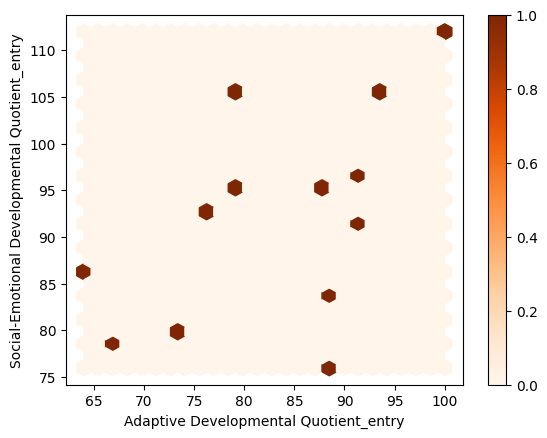

In [146]:
gn_kids.plot.hexbin(x ='Adaptive Developmental Quotient_entry', y ='Social-Emotional Developmental Quotient_entry', gridsize = 25, cmap ='Oranges')

In [ ]:
colors = ['yellow', 'purple', 'pink']

plt.stackplot(df['x'], df['Category A'], df['Category B'], df['Category C'], colors=colors, alpha=0.7)

plt.plot(df['x'], df['Category A'], color='blue', alpha=0.5, linewidth=0.9)
plt.plot(df['x'], df['Category B'], color='green', alpha=0.5, linewidth=0.9)
plt.plot(df['x'], df['Category C'], color='red', alpha=0.5, linewidth=0.9)

plt.title(&quot;Stacked Area Line Plot with Custom Colors&quot;)
plt.xlabel(&quot;X-axis&quot;)
plt.ylabel(&quot;Y-axis&quot;)
plt.legend()
plt.show()